In [1]:
import torch 
import torch.nn as nn
import torchvision.datasets as vision_dsets
from torch.utils import data
import torchvision.transforms as T # Transformation functions to manipulate images

device = "cuda"
# device = "cpu"

def get_mnist_dataloader(root='untracked',train =True,transforms=T.ToTensor() ,download =True,batch_size = 32,num_worker = 1):
    print ("[+] Get the MNIST DATA")
    """
    We will use Mnist data for our tutorial 
    """
    mnist_train = vision_dsets.MNIST(root = root,  #root is the place to store your data. 
                                    train = True,  
                                    transform = transforms,
                                    download=download)
    mnist_test = vision_dsets.MNIST(root = root,
                                    train = False, 
                                    transform = transforms,
                                    download=download)
    """
    Data Loader is a iterator that fetches the data with the number of desired batch size. 
    * Practical Guide : What is the optimal batch size? 
      - Usually.., higher the batter. 
      - We recommend to use it as a multiple of 2 to efficiently utilize the gpu memory. (related to bit size)
    """
    trainDataLoader = data.DataLoader(dataset = mnist_train,  # information about your data type
                                      batch_size = batch_size, # batch size
                                      shuffle =True, # Whether to shuffle your data for every epoch. (Very important for training performance)
                                      num_workers = 1) # number of workers to load your data. (usually number of cpu cores)

    testDataLoader = data.DataLoader(dataset = mnist_test, 
                                    batch_size = batch_size,
                                    shuffle = False, # we don't actually need to shuffle data for test
                                    num_workers = 1) #
    print ("[+] Finished loading data & Preprocessing")
    return trainDataLoader,testDataLoader

trainDataLoader, testDataLoader = get_mnist_dataloader(transforms=T.Compose([T.ToTensor()]))

/home/bumjin/anaconda3/envs/deeping/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[+] Get the MNIST DATA
[+] Finished loading data & Preprocessing


In [2]:
import torch 
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, model="linear"):
        super().__init__()
        self.model_type = model
        if model =="linear":
            self.linear1 = nn.Linear(784, 128)
            self.linear2 = nn.Linear(128, 10)
        elif model == "cnn":
            self.conv1 = nn.Conv2d(in_channels= 1, out_channels=32, kernel_size=3, stride=1)	
            self.conv2 = nn.Conv2d(in_channels=32, out_channels=28, kernel_size=3, stride=2)
            self.fc1 = nn.Linear(in_features=252, out_features=128)
            self.fc2 = nn.Linear(in_features=128, out_features=10)
            self.avg_pool = nn.AvgPool2d(2)
            self.max_pool = nn.MaxPool2d(2)
            
    def forward(self, x):
        batch_size = x.size(0)

        if self.model_type == "linear":
            x = x.view(batch_size, -1)
            x = self.linear1(x)
            x = nn.functional.relu(x)
            x = self.linear2(x) 
        else:
            x = nn.functional.relu(self.conv1(x))
            x = self.max_pool(x)
            x = nn.functional.relu(self.conv2(x))
            x = self.avg_pool(x)
            x = x.contiguous().view(batch_size, -1)
            x = self.fc1(x)
            x = nn.functional.relu(x)
            x = self.fc2(x)
        return x 



In [3]:
linear_model = Model(model="linear").to(device=device)
cnn_model = Model(model="cnn").to(device=device)

In [4]:
import torch.optim as optim
from torch.autograd import Variable


def train(net, train_loader, optimizer, criterion,  epoch=2):
    net.train()
    for e in range(epoch):
        running_loss = 0.0  
        for i, data in enumerate(train_loader, 0): 
            # get the inputs
            inputs, labels = data # Return type for data in dataloader is tuple of (input_data, labels)
            inputs = Variable(inputs).to(device=device)
            labels = Variable(labels).to(device=device)
            # zero the parameter gradients
            optimizer.zero_grad()    

            # forward + backward + optimize
            outputs = net(inputs) # get output after passing through the network
            loss = criterion(outputs, labels) # compute model's score using the loss function 
            loss.backward() # perform back-propagation from the loss
            optimizer.step() # perform gradient descent with given optimizer

            # print statistics
            running_loss += loss.item()
            if (i+1) % 500 == 0:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / 500))
                running_loss = 0.0


criterion = nn.CrossEntropyLoss() 

models = [
    linear_model, 
    cnn_model
]

optimizers  = [
    torch.optim.Adam(linear_model.parameters(), lr=0.001,),
    torch.optim.Adam(cnn_model.parameters(), lr=0.001, )
]


for model, opti, in zip(models, optimizers):
    print("--- Training Started with model ---")
    print(model)
    train(model, trainDataLoader, opti, criterion, 2)


--- Training Started with model ---
Model(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
)
[1,   500] loss: 0.510
[1,  1000] loss: 0.254
[1,  1500] loss: 0.227
[2,   500] loss: 0.153
[2,  1000] loss: 0.138
[2,  1500] loss: 0.125
--- Training Started with model ---
Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 28, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=252, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
[1,   500] loss: 0.727
[1,  1000] loss: 0.248
[1,  1500] loss: 0.172
[2,   500] loss: 0.131
[2,  1000] loss: 0.112
[2,  1500] loss: 0.097


### Linear Layer Relevance

In [5]:

import sys
sys.path.append("../../")
from lrp_perfect import LRP

x = trainDataLoader.dataset[10][0].clone()
x = x.to("cuda").view(1, 784)

layers = [
    linear_model.linear1, 
    nn.ReLU(), 
    linear_model.linear2
]

rule_descriptions = [
    {'gamma' : 0.2 , "epsilon" :0.2},
    {},
    {"epsilon" : 1e-9}
]

lrp_model = LRP(layers, rule_descriptions, device="cuda")

relevances, activations = lrp_model.forward(x)
relevances[-1] = relevances[-1].view(28,28,1)

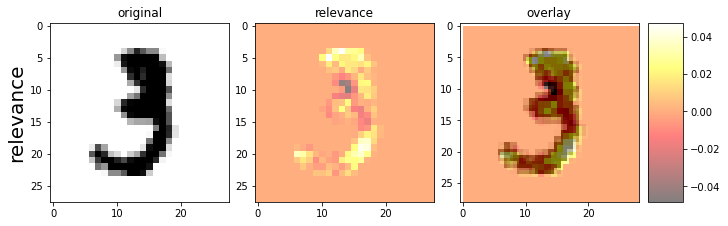

In [6]:

import copy 
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(10,10))

for i, (input_attribution, name) in enumerate(zip([relevances[-1]], ["relevance"])):
    input = x.detach().cpu().view(28,28,1)
    input_attribution = input_attribution.cpu()
    ax[0].imshow(input, cmap='binary')
    ax[1].imshow(copy.deepcopy(input_attribution), alpha=0.5, cmap='hot')
    ax[2].imshow(input, cmap='binary')
    ax[0].set_ylabel(name, fontsize=20)

ax[0].set_title("original")
ax[1].set_title("relevance")
ax[2].set_title("overlay")

pcm1 = ax[2].pcolormesh(relevances[-1].view(28,28).cpu(), alpha=0.5, cmap='hot')
cax = ax[2].inset_axes([1.05, 0.0, 0.2, 1.0], transform=ax[2].transAxes)
fig.colorbar(pcm1, ax=ax[2], cax=cax)

plt.show()



## Convolution Relevance

In [22]:

import sys
sys.path.append("../../")
from lrp_perfect import LRP

x = trainDataLoader.dataset[10][0].clone()
x = x.to("cuda").view(1, 1, 28, 28)

layers = [
    cnn_model.conv1, 
    nn.ReLU(), 
    cnn_model.max_pool,

    cnn_model.conv2, 
    nn.ReLU(),
    cnn_model.avg_pool,

    nn.Flatten(),
    cnn_model.fc1,
    nn.ReLU(),
    cnn_model.fc2    
]

rule_descriptions = [
    {'gamma' : 0.1 , "epsilon" :0.5},
    {},
    { "epsilon" :1e-9},

    {'gamma' : 0.1 , "epsilon" :0.5},
    {},
    { "epsilon" :1e-9},

    {},
    {"epsilon" : 1e-9},
    {},
    {"epsilon" : 1e-9}
]

lrp_model = LRP(layers, rule_descriptions, device="cuda")

relevances, activations = lrp_model.forward(x)
relevances[-1] = relevances[-1].view(28,28,1)

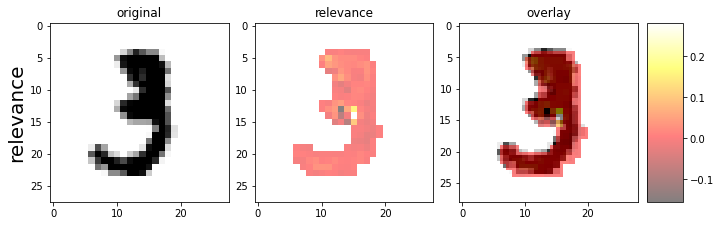

In [23]:

import copy 
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(10,10))

for i, (input_attribution, name) in enumerate(zip([relevances[-1]], ["relevance"])):
    input = x.detach().cpu().view(28,28,1)
    input_attribution = input_attribution.cpu()
    ax[0].imshow(input, cmap='binary')
    ax[1].imshow(copy.deepcopy(input_attribution), alpha=0.5, cmap='hot')
    ax[2].imshow(input, cmap='binary')
    ax[0].set_ylabel(name, fontsize=20)

ax[0].set_title("original")
ax[1].set_title("relevance")
ax[2].set_title("overlay")

pcm1 = ax[2].pcolormesh(relevances[-1].view(28,28).cpu(), alpha=0.5, cmap='hot')
cax = ax[2].inset_axes([1.05, 0.0, 0.2, 1.0], transform=ax[2].transAxes)
fig.colorbar(pcm1, ax=ax[2], cax=cax)

plt.show()

